# Tiny NeRF with PyTorch

In [ ]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Download Data

* The code loads a dataset from `tiny_nerf_data.npz` which includes images, camera poses, and the focal length.
* For each image, only the first three channels (RGB) are used.



In [ ]:
# 데이터 다운로드
if not os.path.exists('tiny_nerf_data.npz'):
    os.system("wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz")

# Load Input Images and Camera Poses

The variable poses has the shape `(N,4,4)`, where $N$ is the number of training images.
* Each $4\times4$ matrix is a <b>homogeneous transformation matrix</b> that contains the extrinsic parameters of the camera.

In [ ]:
# 데이터 불러오기
data = np.load('tiny_nerf_data.npz')
images = data['images']       # (N, H, W, 4) 형태였으나 나중에 RGB만 사용
poses = data['poses']         # (N, 4, 4)
focal = data['focal'].item()  # 스칼라
H, W = images.shape[1:3]
print("Images:", images.shape, "Poses:", poses.shape, "Focal:", focal)


# -- holdout view (예: index 101)
index = 101
testimg = images[index, ..., :3] # (frame_idx, H,W,C)
testpose = poses[index]

# -- 학습에는 처음 100개 이미지 사용
images = images[:100, ..., :3]
poses = poses[:100]


plt.figure(figsize=(3, 3))
plt.imshow(testimg)
plt.title("Holdout Image")
plt.show()

The image values are in the [0,1] range. That is, it is already normalized.

In [ ]:
print(testimg.min())
print(testimg.max())

# Optimize NeRF

## Positional Encoding
NeRF uses positional encoding to map input 3D coordinates into a higher dimensional space. This allows the network to learn high-frequency details (such as fine textures).

For a 3D point $\mathbf{x}$ with coordinates [$x,y,z$], the encoding creates a new vector that includes:
* The original coordinates: $\mathbf{x}$
* For each frequency $2^i$ (with $i$ from $0$ to $L-1$ for $L$ embedding levels):
    * $\text{sin}(2^{i}x)$
    * $\text{cos}(2^{i}x)$


<b>Mathematical Derivation</b>:
* If $\mathbf{x}\in \mathbb{R}^{3}$ and $L=6$, the final encoded vector has a dimension:
$$
3+3 \times (2\times 6)=3+36 = 39
$$

In [ ]:
# --------------------------------------------
# 1. Positional Encoding 함수
# --------------------------------------------
# L_embed = 6  # 주파수 수
def posenc(x, L_embed=6):
    """
    x: (N, 3) 또는 (..., 3)
    반환: 원래 x와 함께 sin, cos 주파수들이 concat된 텐서
    """
    out = [x]
    for i in range(L_embed):
        out.append(torch.sin((2.0 ** i) * x))
        out.append(torch.cos((2.0 ** i) * x))
    return torch.cat(out, dim=-1)  # 마지막 차원에 concat

## NeRF Model Architecture

<b>Network Structure</b>: </br>
The network is an 8-layer multilayer perceptron (MLP) with 256 neurons per layer.
* A <b>skip connection</b> is applied after the fourth layer to reintroduce the original positional encoding, which helps the network learn better by providing a direct path for the input features.

<b>Skip Connection Details</b>: </br>
Before the Skip Connection
* The input is 39-dimensional (from positional encoding).
* Layers 0–3 output a 256-dimensional vector.

After the Fourth Layer:
* The network output (256-dimensional) is concatenated with the original 39-dimensional input, giving a new input dimension of $256+39=295$ for the next layer.

Output:
* The final layer produces 4 outputs (RGB color channels + one density value $\sigma$).

In [ ]:
# --------------------------------------------
# 2. NeRF 모델 (PyTorch)
# --------------------------------------------
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, L_embed=6):
        """
        D: 전체 레이어 수 (예: 8)
        W: 각 레이어의 출력 노드 수 (예: 256)
        input_ch: 원래 좌표 차원 (예: 3)
        L_embed: 주파수 수 (예: 6) -> 최종 입력 차원은 3 + 3*2*6 = 39
        """
        super(NeRF, self).__init__()
        self.L_embed = L_embed
        self.input_ch = input_ch
        self.input_dim = input_ch + input_ch * 2 * L_embed  # 3 + 36 = 39
        self.D = D
        self.W = W

        self.layers = nn.ModuleList()
        for i in range(D):
            if i == 0:
                in_dim = self.input_dim
            # skip connection가 레이어 4 이후에 적용되므로,
            # 레이어 4는 그대로 256을 기대하고, 그 다음 레이어(즉, i==5)가 256+39를 입력으로 받음.
            elif i == 5:  # layer after skip connection; expects 256+39 dimensions.
                in_dim = W + self.input_dim  # 256 + 39 = 295
            else:
                in_dim = W
            self.layers.append(nn.Linear(in_dim, W))
        self.output_layer = nn.Linear(W, 4)  # Final output: [R, G, B, sigma]

    def forward(self, x):
        # x: (N, input_dim)
        input_x = x  # Save original positional encoding
        h = x
        for i in range(self.D):
            h = self.layers[i](h)
            h = F.relu(h)
            if i == 4: # After layer 4, add skip connection.
                h = torch.cat([h, input_x], dim=-1)
        outputs = self.output_layer(h)
        return outputs

## Ray Generation

Convert image pixel coordinates into rays (origins and directions) using the camera’s intrinsic parameters (focal length) and extrinsic parameters (pose).
* <b>Meshgrid Creation</b>: Generates a grid of pixel coordinates.
* <b>Normalization</b>: Adjusts pixel positions so the camera is centered by subtracting half the width and height and then divides by the focal length.
* <b>Transformation</b>: Rotates the directions using the camera’s rotation matrix (extracted from the pose) and adds the translation vector.



In [ ]:
# --------------------------------------------
# 3. 광선(rays) 생성 함수
# --------------------------------------------
def get_rays(H, W, focal, c2w):
    """
    c2w: (4,4) 카메라 자세 (numpy array)
    반환: rays_o, rays_d (각각 (H, W, 3) 텐서)
    """
    i, j = torch.meshgrid(torch.arange(W, dtype=torch.float32),
                            torch.arange(H, dtype=torch.float32),
                            indexing='xy')
    # -- dirs: 카메라 좌표계에서의 ray 방향
    dirs = torch.stack([(i - W * 0.5) / focal,
                        -(j - H * 0.5) / focal,
                        -torch.ones_like(i)], dim=-1)  # (H, W, 3)

    # -- 카메라 좌표계를 월드 좌표계로 변환:
    R = torch.from_numpy(c2w[:3, :3]).float()  # Rotation matrix from the pose matrix; (3,3)
    t = torch.from_numpy(c2w[:3, 3]).float()   # Translation vector from the pose matrix; (3,)

    # -- 각 픽셀에 대해 회전 적용 (행렬 곱셈)
    rays_d = torch.matmul(dirs.view(-1, 3), R.t()).view(H, W, 3)

    # -- 모든 픽셀에 동일한 원점(카메라 위치)
    rays_o = t.expand((H, W, 3))
    return rays_o, rays_d

## Volume Rendering and Ray Sampling

Compute the color of a pixel by integrating the contributions along a ray. This mimics how light accumulates in a real scene.

(1) Sample Points along the Ray:
* For each ray, sample $N$ points evenly spaced between a near and far distance.
* Optionally add random noise to the sampling positions:
$$ z_{\text{vals}}=\text{linespace}(\text{near}, \text{far},N)+\text{noise}$$



(2) 3D Point Computation:
* A point along a ray is calculated as a line equation:
$$\mathbf{b}=\mathbf{o}+z \cdot \mathbf{d},$$
where $\mathbf{o}$ is the ray origin and $\mathbf{d}$ is the ray direction.

(3) Positional Encoding:
* Each point $\mathbf{p}$ is transformed using `posenc` to form the network’s input.

(4) Network Prediction:
* The network outputs raw values that are split into:
    * <b>Color</b> : Processed with a sigmoid to yield values in [0,1].
    * <b>Density</b> ($\sigma$): Processed with ReLU to ensure non-negativity.

(5) Volume Rendering Integration:
* Alpha Calculation:
    * Compute the opacity for each point:
    $$\alpha_{i} = 1 - \text{exp}(-\sigma_{i} \Delta_{i}),$$
    where $\Delta_{i}$ is the distance between adjacent samples.
* Color Contribution Weight Computation:
    * The weight for the $i$-th sample is:
    $$w_{i}=\alpha_{i} \prod_{j=1}^{i-1}(1-\alpha_{i}).$$
    The product is the <b>transmittance</b> and represents the portion of light that has not been blocked before reaching the $i$-th point.
* Final Color and Depth:
    * The pixel's color is computed as:
    $$\textbf{RGB}=\sum_{i}w_{i}\mathbf{c}_{i},$$

    where $\mathbf{c}_{i} \in \mathbb{R}^{3}$.
    * The depth is:
    $$\text{depth}=\sum_{i}w_{i}z_{i}.$$



In [ ]:
# --------------------------------------------
# 4. 볼륨 렌더링: 광선 따라 네트워크 평가
# --------------------------------------------
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False, chunk=1024*32):
    """
    network_fn: NeRF 모델
    rays_o, rays_d: (H, W, 3)
    near, far: 렌더링 범위
    N_samples: 각 광선당 샘플 수
    rand: 샘플링 위치에 랜덤 노이즈 추가 여부
    chunk: 메모리 문제를 피하기 위한 chunk 단위 처리
    반환: rgb_map (H, W, 3), depth_map (H, W), acc_map (H, W)
    """
    device = rays_o.device  # Get the device from rays_o (should be cuda if on GPU)

    # 1. 광선 위의 z 좌표 샘플링
    z_vals = torch.linspace(near, far, steps=N_samples, device=device)
    if rand:
        noise = torch.rand(rays_o.shape[:2] + (N_samples,), device=device) * (far - near) / N_samples
        z_vals = z_vals.unsqueeze(0).unsqueeze(0) + noise  # (H, W, N_samples)
    else:
        z_vals = z_vals.unsqueeze(0).unsqueeze(0)  # (1, 1, N_samples)

    # 2. 각 광선에 대해 3D 점 좌표 계산
    pts = rays_o.unsqueeze(2) + rays_d.unsqueeze(2) * z_vals.unsqueeze(-1)  # (H, W, N_samples, 3)
    pts_flat = pts.reshape(-1, 3)  # (H*W*N_samples, 3)

    # 3. 위치 인코딩 후 모델 평가 (메모리 chunk 처리)
    pts_embed = posenc(pts_flat, L_embed=6)  # (num_points, input_dim)
    raw_chunks = []
    for i in range(0, pts_embed.shape[0], chunk):
        raw_chunks.append(network_fn(pts_embed[i:i+chunk]))
    raw = torch.cat(raw_chunks, dim=0)
    raw = raw.reshape(pts.shape[:-1] + (4,))  # (H, W, N_samples, 4)

    sigma_a = F.relu(raw[..., 3])        # 밀도, 음수가 없도록 ReLU
    rgb = torch.sigmoid(raw[..., :3])    # 색상 (0~1 범위)

    # 4. 광선 간격 (거리)
    dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1],
                       1e10 * torch.ones_like(z_vals[..., :1])], dim=-1)

    # 5. 각 샘플의 투과도(opacity, alpha) 계산
    alpha = 1 - torch.exp(-sigma_a * dists)

    # 6. 누적 곱 (exclusive cumprod): 첫 항은 1로 시작
    ones = torch.ones(alpha.shape[:-1] + (1,), device=alpha.device)
    shifted = torch.cat([ones, 1 - alpha + 1e-10], dim=-1)
    cumprod = torch.cumprod(shifted, dim=-1)[..., :-1]
    weights = alpha * cumprod

    # 7. 색상 및 깊이 복원
    rgb_map = torch.sum(weights.unsqueeze(-1) * rgb, dim=-2)
    depth_map = torch.sum(weights * z_vals, dim=-1)
    acc_map = torch.sum(weights, dim=-1)

    return rgb_map, depth_map, acc_map

##  Training Loop and Loss Computation

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

Training Process:
* In each iteration, a random image is selected.
* The corresponding camera pose is used to generate rays.
* The network renders an image from these rays.
* The loss is computed as Mean Squared Error (MSE) between the rendered image and the target.
* Peak Signal-to-Noise Ratio (PSNR) is calculated by:
$$\text{PSNR}=-10 \cdot \text{log}_{10}(loss) $$

In [ ]:
# --------------------------------------------
# 5. 학습 및 렌더링 설정
# --------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeRF().to(device)
# optimizer = optim.Adam(model.parameters(), lr=5e-4)
optimizer = optim.Adam(model.parameters(), lr=5e-4, eps=1e-8, betas=(0.9, 0.999))

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

Start training...
Iter: 0, 0.065 sec/iter, Test Loss: 0.140630, PSNR: 8.52


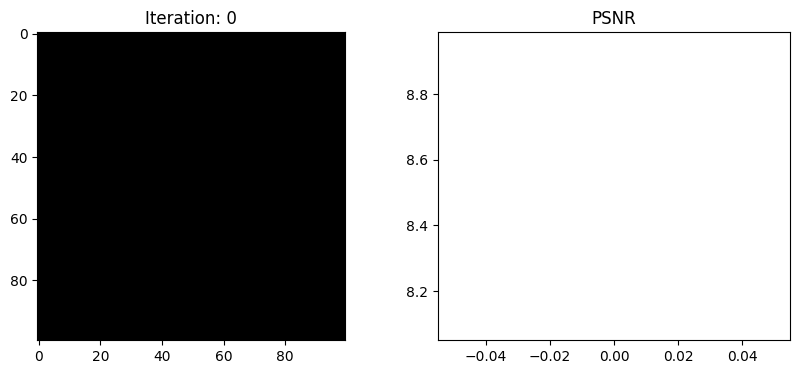

Iter: 25, 0.569 sec/iter, Test Loss: 0.140630, PSNR: 8.52


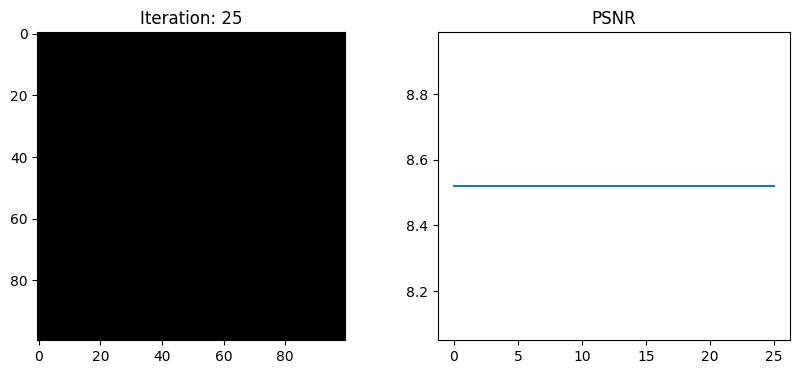

Iter: 50, 0.584 sec/iter, Test Loss: 0.140630, PSNR: 8.52


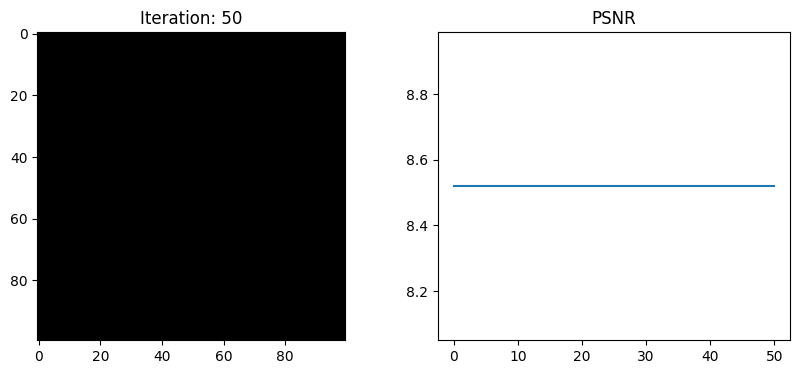

Iter: 75, 0.593 sec/iter, Test Loss: 0.140630, PSNR: 8.52


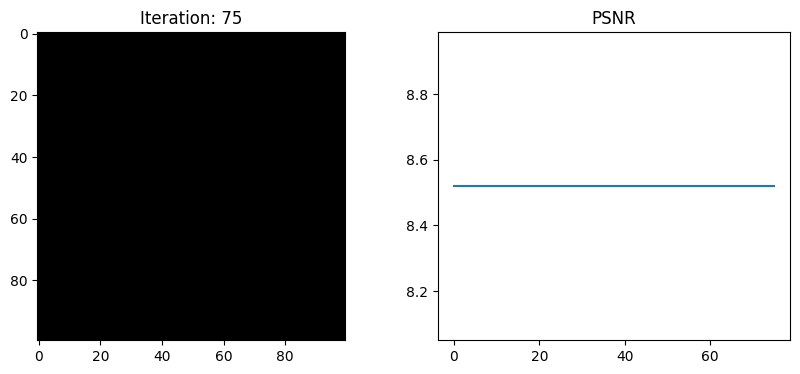

Iter: 100, 0.602 sec/iter, Test Loss: 0.140630, PSNR: 8.52


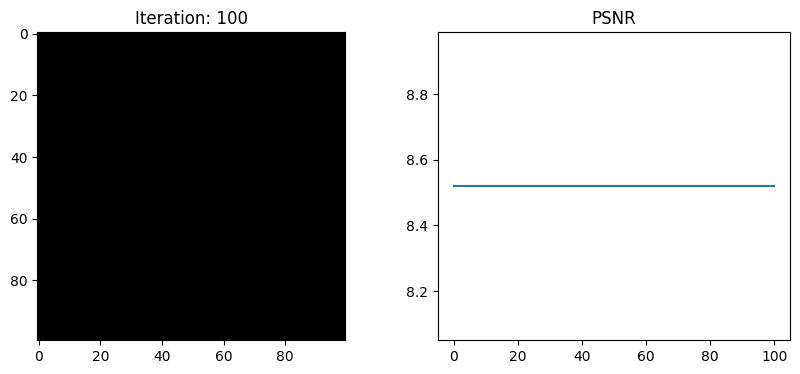

Iter: 125, 0.612 sec/iter, Test Loss: 0.140630, PSNR: 8.52


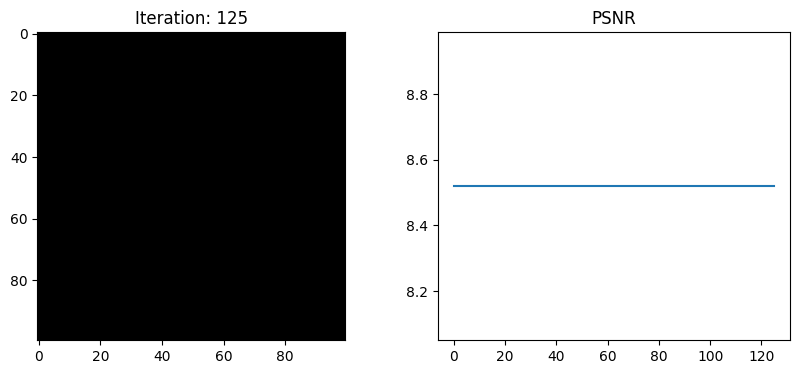

Iter: 150, 0.622 sec/iter, Test Loss: 0.140630, PSNR: 8.52


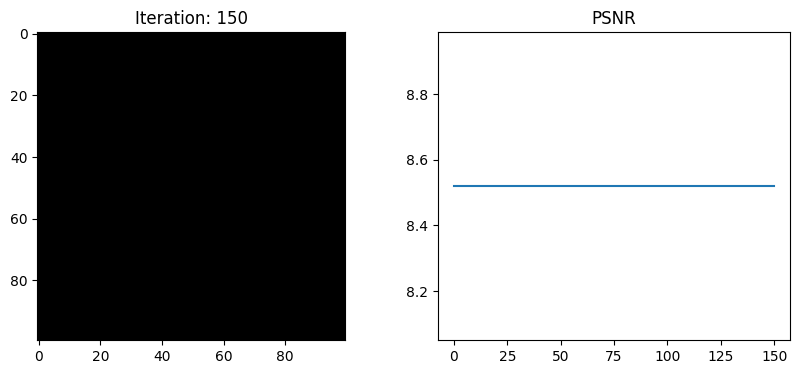

Iter: 175, 0.632 sec/iter, Test Loss: 0.140630, PSNR: 8.52


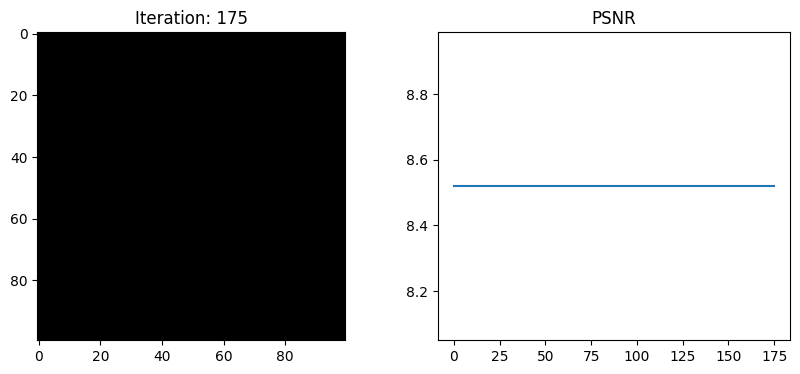

Iter: 200, 0.644 sec/iter, Test Loss: 0.140630, PSNR: 8.52


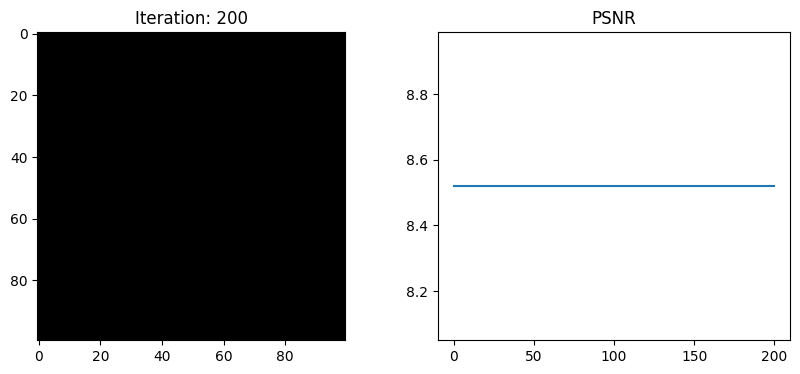

Iter: 225, 0.640 sec/iter, Test Loss: 0.140630, PSNR: 8.52


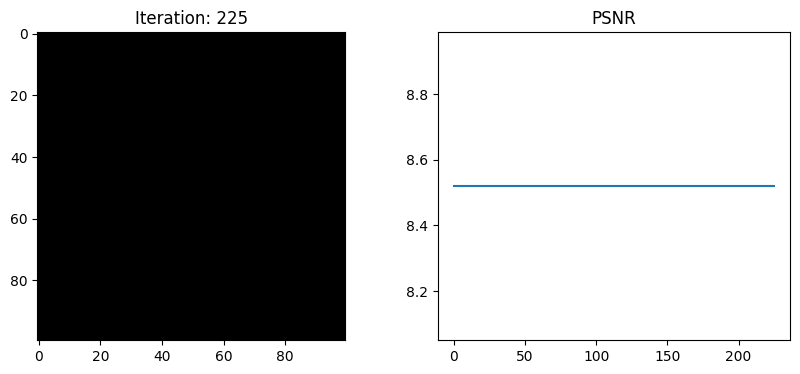

Iter: 250, 0.632 sec/iter, Test Loss: 0.140630, PSNR: 8.52


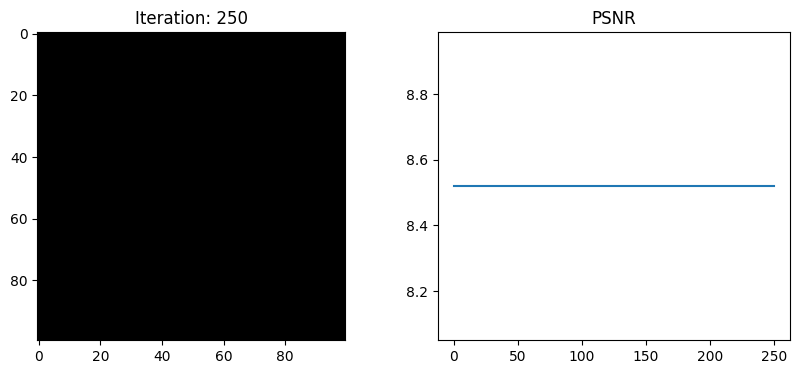

Iter: 275, 0.631 sec/iter, Test Loss: 0.140630, PSNR: 8.52


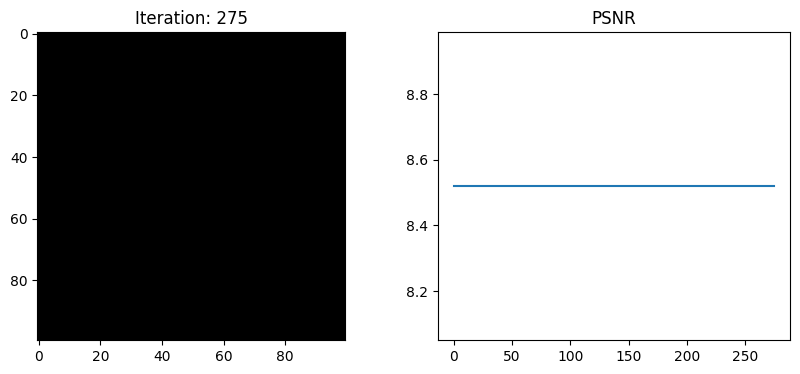

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 14.12 MiB is free. Process 35376 has 14.72 GiB memory in use. Of the allocated memory 14.45 GiB is allocated by PyTorch, and 146.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# 학습 데이터는 numpy로 로드한 후, 매번 필요한 이미지는 torch.Tensor로 변환

def load_target(img):
    # img: (H, W, 3)
    # 학습 데이터는 numpy로 로드한 후, 매번 필요한 이미지는 torch.Tensor로 변환
    # (이미지 픽셀은 [0,1] 범위로 정규화 돼 있음)
    #return torch.from_numpy(img).to(device)
    return torch.from_numpy(img.astype(np.float32)).to(device)

print("Start training...")
t0 = time.time()
for i in range(N_iters+1):
    # 이미지 인덱스 랜덤 선택
    img_i = np.random.randint(images.shape[0])
    target = load_target(images[img_i])
    pose = poses[img_i]  # (4,4) numpy array

    # 광선 생성
    rays_o, rays_d = get_rays(H, W, focal, pose)
    rays_o = rays_o.to(device)
    rays_d = rays_d.to(device)

    # 네트워크 평가: 랜덤 노이즈 포함
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2.0, far=6.0, N_samples=N_samples, rand=True)

    # 손실: MSE
    loss = F.mse_loss(rgb, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % i_plot == 0:
        dt = (time.time() - t0) / i_plot
        t0 = time.time()
        # -- Render the holdout view for logging
        rays_o_test, rays_d_test = get_rays(H, W, focal, testpose)
        rays_o_test = rays_o_test.to(device)
        rays_d_test = rays_d_test.to(device)
        rgb_test, depth_test, acc_test = render_rays(model, rays_o_test, rays_d_test, near=2.0, far=6.0, N_samples=N_samples, rand=False)
        test_loss = F.mse_loss(rgb_test, load_target(testimg))
        psnr = -10.0 * torch.log(test_loss) / torch.log(torch.tensor(10.0))

        psnrs.append(psnr.item())
        iternums.append(i)
        print(f"Iter: {i}, {dt:.3f} sec/iter, Test Loss: {test_loss.item():.6f}, PSNR: {psnr.item():.2f}")

        # -- Visualization
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(torch.clamp(rgb_test, 0, 1).detach().cpu().numpy())
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print("Training done.")

# Interactive Visualization

In [ ]:
import ipywidgets as widgets
from IPython.display import HTML
import imageio
from base64 import b64encode

Post-Training Visualization:
* The code provides interactive widgets to adjust camera parameters (theta, phi, radius) so you can view the scene from different angles.
* A helper function (`pose_spherical`) converts spherical coordinates into a camera-to-world matrix.
* Finally, frames are rendered and compiled into a video showing a rotating view of the scene.

In [ ]:
# --------------------------------------------
# 6. 카메라 변환 함수 (인터랙티브 렌더링 및 동영상 생성)
# --------------------------------------------
def trans_t(t):
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ], dtype=np.float32)

def rot_phi(phi):
    phi = np.radians(phi)
    return np.array([
        [1, 0, 0, 0],
        [0, np.cos(phi), -np.sin(phi), 0],
        [0, np.sin(phi),  np.cos(phi), 0],
        [0, 0, 0, 1],
    ], dtype=np.float32)

def rot_theta(th):
    th = np.radians(th)
    return np.array([
        [ np.cos(th), 0, -np.sin(th), 0],
        [0, 1, 0, 0],
        [ np.sin(th), 0,  np.cos(th), 0],
        [0, 0, 0, 1],
    ], dtype=np.float32)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi) @ c2w
    c2w = rot_theta(theta) @ c2w
    # 고정 변환
    c2w = np.array([
        [-1, 0, 0, 0],
        [0,  0, 1, 0],
        [0,  1, 0, 0],
        [0,  0, 0, 1],
    ], dtype=np.float32) @ c2w
    return c2w

def render_image_from_pose(c2w):
    rays_o, rays_d = get_rays(H, W, focal, c2w)
    rays_o = rays_o.to(device)
    rays_d = rays_d.to(device)
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2.0, far=6.0, N_samples=N_samples, rand=False)
    img = torch.clamp(rgb, 0, 1).detach().cpu().numpy()
    return img

def f(theta, phi, radius):
    c2w = pose_spherical(theta, phi, radius)
    img = render_image_from_pose(c2w)
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.title(f'theta: {theta}, phi: {phi}, radius: {radius}')
    plt.show()

In [ ]:
sldr = lambda v, mi, ma: widgets.FloatSlider(value=v, min=mi, max=ma, step=0.01)
names = [
    ['theta', [100., 0., 360]],
    ['phi',   [-30., -90, 0]],
    ['radius',[4., 3., 5]],
]
interactive_plot = widgets.interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
display(interactive_plot)

# Render 360 Video

In [ ]:
# --------------------------------------------
# 7. 동영상 생성
# --------------------------------------------
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    img = render_image_from_pose(c2w)
    frames.append((255 * np.clip(img, 0, 1)).astype(np.uint8))

video_filename = 'video.mp4'
imageio.mimwrite(video_filename, frames, fps=30, quality=7)

In [ ]:
# HTML로 동영상 표시
mp4 = open(video_filename, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=400 controls autoplay loop>
  <source src="{data_url}" type="video/mp4">
</video>
""")

# Reference
* https://www.matthewtancik.com/nerf
* https://github.com/yenchenlin/nerf-pytorch
* https://github.com/bmild/nerf
* https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb
